# Viscosity Interpolation

Some tests, examples of viscosity interpolation

As a rule, visoscity varies exponentially with temperature, so that's how we onterpolatie it

But something seemed wrong with some dat from LSFOs

Here's a check, using the KinematicViscosity Object from adios_db.computation

## Conclusion so far:

The fit to an exponential works well for crude oils -- which is what we determined way back when.

However -- it works really poorly for at least some ULSFOs -- maybe other distilled products as well.

## Solution?

First step is to check the residuals, and at least issue a warning.

Next step is to come up with a better interolatio method -- we could do piecwise (linear or exponential), but thatmight extrapolate really badly. That may not be SO bad for environmental conditions -- not a huge temp range --  but not great for labeling and the like.

I tried using only the outside two pooints -- not good.

Could a 3 parameter exponential fit work? IN theory, it should't -- viscosity should tend to zero at infinite temperature, but maybe it wold work OK locally -- at least it would exactly fit three points :-)

Hmm -- piecewise exponential, with the extrapolation using a the fit to the end points?




In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot  as plt
import matplotlib
import adios_db.scripting as ads
import adios_db.computation.physical_properties as pp
import csv
import nucos

In [2]:
# Here's an LSFO with dynamic viscosity data:
EXAMPLE_DATA_DIR = Path(r"C:\Users\rintaro.moriyasu\Oil Databases\noaa-oil-data\data\oil")

with open("viscosity_data.csv") as infile:
    reader = csv.reader(infile)
    next(reader)
    oil_ids = [row[2].strip() for row in reader]

json_files = [EXAMPLE_DATA_DIR/id[:2]/(id+".json") for id in oil_ids]
#json_files = [EXAMPLE_DATA_DIR/"EC"/"EC00519.json"]
#print(json_files)

In [3]:
oils = [ads.Oil.from_file(filename) for filename in json_files]

In [4]:
residuals = {}
no_list = ['AD00813', 'NO00119', 'NO00120','NO00121','NO00122', 'AD02582', 'AD01485' ]
matplotlib.rcParams['figure.max_open_warning'] = 240
counter = 0
for oil in oils[:]:
    validation = oil.validate()
    bad_oil = False
    for message in validation:
        if message.startswith("E062"):
            print("Skipping", oil.oil_id)
            bad_oil = True
            break
    if oil.oil_id in no_list:
        print("Skipping because no list")
        continue
    if bad_oil:
        print("Skipping because bad oil")
        continue
    
        
    oil_name = oil.metadata.name
    #print(oil_name)
    KV = pp.KinematicViscosity(oil)

    visc = KV.kviscs
    if len(visc) < 3:
        print("Skipping because len(visc) < 3")
        continue
    
    if KV.residuals[0] > 0.02:
        print("Skipping because res > 0.02")
        counter += 1
        continue
    temps = np.array(KV.temps)
    visc2 = KV.at_temp(temps)
    residuals[oil.oil_id] = KV.residuals[0]
    temps_c = nucos.convert("K", "C", temps)
    temps3 = np.linspace(min(temps), max(temps))
    temps3_c = nucos.convert("K", "C", temps3)
    visc3 = KV.at_temp(temps3)
#     fig, ax = plt.subplots()
#     ax.set_title(oil_name +" " + oil.oil_id)
#     ax.plot(temps_c, visc, 'o')
#     ax.plot(temps_c, visc2, 'x')
#     ax.plot(temps3_c, visc3)
#     ax.set_xlabel("Temp in C")
#     ax.set_ylabel("Viscosity")
#     ax.legend(["original points", "re-computed", "interpolator"])
#     ax.text(min(temps3_c),min(visc3) , f"Residual: {KV.residuals}")
print("Records w/ Bad Residuals =", counter)

Skipping AD00813
Skipping because no list
Skipping because res > 0.02
Skipping AD01266
Skipping because bad oil
Skipping because res > 0.02
Skipping because res > 0.02
Skipping because res > 0.02
Skipping because res > 0.02
Skipping because res > 0.02
Skipping because res > 0.02
Skipping because res > 0.02
Skipping because res > 0.02
Skipping AD01483
Skipping because bad oil
Skipping because res > 0.02
Skipping because no list
Skipping because res > 0.02
Skipping because res > 0.02
Skipping because res > 0.02
Skipping AD02078
Skipping because bad oil
Skipping AD02082
Skipping because bad oil
Skipping AD02132
Skipping because bad oil
Skipping AD02151
Skipping because bad oil
Skipping AD02206
Skipping because bad oil
Skipping because res > 0.02
Skipping because res > 0.02
Skipping AD02270
Skipping because bad oil
Skipping because res > 0.02
Skipping because res > 0.02
Skipping because res > 0.02
Skipping because no list
Skipping because res > 0.02
Skipping because len(visc) < 3
Skipping 

(array([126.,  19.,  10.,   4.,   5.,   3.,   5.,   2.,   2.,   3.,   2.,
          0.,   0.,   3.,   0.,   6.,   1.,   0.,   2.,   7.]),
 array([6.82957823e-08, 9.76343414e-04, 1.95261853e-03, 2.92889365e-03,
        3.90516877e-03, 4.88144389e-03, 5.85771901e-03, 6.83399412e-03,
        7.81026924e-03, 8.78654436e-03, 9.76281948e-03, 1.07390946e-02,
        1.17153697e-02, 1.26916448e-02, 1.36679200e-02, 1.46441951e-02,
        1.56204702e-02, 1.65967453e-02, 1.75730204e-02, 1.85492955e-02,
        1.95255707e-02]),
 <BarContainer object of 20 artists>)

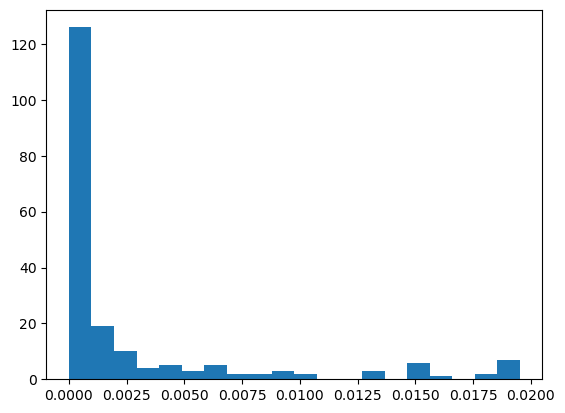

In [5]:
res = list(residuals.values())
fig, ax = plt.subplots()
ax.hist(res, bins = 20)
#     ax.set_title(oil_name +" " + oil.oil_id)
#     ax.plot(temps, visc, 'o')
#     ax.plot(temps, visc2, 'x')
#     ax.plot(temps3, visc3)
#     ax.legend(["original points", "re-computed", "interpolator"])
#     ax.text(min(temps3),min(visc3) , f"Residual: {KV.residuals}")

In [6]:
max(res)
res_reversed = {res:id for id, res in residuals.items()}
res_reversed[max(res)]
res_reversed[min(res)]

'AD01863'

In [7]:
matplotlib.rcParams['figure.max_open_warning'] = 240

In [8]:
len(res)

200